In [1]:
import pandas as pd
import numpy as np
df  = pd.read_excel("C:/Users/user/Desktop/計量報告/fama20年總表.xlsx") 


# - 報酬率（return）
# 假設您的報酬率欄位名為 '報酬率(%)'
# 創建新的報酬率欄位（轉換為小數）
df['報酬率'] = df['報酬率％_月'] / 100
df['市值'] = df['收盤價(元)_月']*df['流通在外股數(千股)']
# 假設公司代碼欄位名為 '代號'

# 1. 計算總共有多少不同的公司
total_companies = df['代號'].nunique()
print(f"總公司數量: {total_companies}")


# 3. 查看每年每季的公司數量
quarterly_companies = df.groupby(['年月'])['代號'].nunique()
print("\n每月公司數量:")
print(quarterly_companies)
print(df['報酬率'].head())
print(df['市值'].head())



總公司數量: 83

每月公司數量:
年月
2005/04    39
2005/05    39
2005/06    39
2005/10    39
2005/11    39
           ..
2024/05    83
2024/06    83
2024/07    83
2024/08    83
2024/09    83
Name: 代號, Length: 219, dtype: int64
0    0.052176
1   -0.036314
2   -0.002744
3   -0.039472
4    0.104651
Name: 報酬率, dtype: float64
0    3018399.45
1    2868726.75
2    2976823.70
3    2985138.85
4    3108203.07
Name: 市值, dtype: float64


In [3]:

# 確保 DataFrame 包含 'Ticker' 和 '市值' 兩列
if '名稱' not in df.columns or '市值' not in df.columns:
    raise ValueError("DataFrame must contain 'Ticker' and '市值' columns.")

# 根據市值排序
df = df.sort_values(by='市值', ascending=False)

# 計算前 50% 和後 50% 的分界線
median_market_cap = df['市值'].median()

# 分為前 50% 和後 50%
top_50 = df[df['市值'] > median_market_cap]
bottom_50 = df[df['市值'] <= median_market_cap]

# 隨機選擇一檔股票
random_top_stock = top_50.sample(n=1)
random_bottom_stock = bottom_50.sample(n=1)

# 輸出結果
print("Random stock from top 50% by market cap:")
print(random_top_stock)

print("\nRandom stock from bottom 50% by market cap:")
print(random_bottom_stock)

Random stock from top 50% by market cap:
         代號  名稱       年月  開盤價(元)_月  最高價(元)_月  最低價(元)_月  收盤價(元)_月  成交量(百萬股)_月  \
10215  6239  力成  2024/03    150.28    200.53    146.45    191.92         275   

       成交值(百萬元)_月   報酬率％_月  ...  季底應收帳款/營收TSE  季底存貨/營收TSE  每人營收  每人營業利益  \
10215       50648  28.5259  ...         93.11       34.22   NaN     NaN   

         季底普通股市值  當季季底P/E  當季季底P/B  月       報酬率            市值  
10215  152208773    15.56     2.68  3  0.285259  1.456955e+08  

[1 rows x 122 columns]

Random stock from bottom 50% by market cap:
         代號  名稱       年月  開盤價(元)_月  最高價(元)_月  最低價(元)_月  收盤價(元)_月  成交量(百萬股)_月  \
13216  8261  富鼎  2015/01      26.7      26.7     24.12     25.47           2   

       成交值(百萬元)_月  報酬率％_月  ...  季底應收帳款/營收TSE  季底存貨/營收TSE    每人營收  每人營業利益  \
13216          55 -4.4305  ...         89.31      116.79  3702.0   460.0   

       季底普通股市值  當季季底P/E  當季季底P/B  月       報酬率          市值  
13216  4832874    20.36     2.06  1 -0.044305  4627466.01  

[1 rows x 122 c

In [7]:
# ... existing code ...
# 列出所有不同的公司代碼
unique_companies = df['名稱'].unique()

# 將公司代碼轉換為 DataFrame
companies_df = pd.DataFrame(unique_companies, columns=['公司名稱'])

# 打印公司代碼表
print("不同的公司名稱:")
print(companies_df)
# ... existing code ...

不同的公司名稱:
   公司名稱
0    麗正
1    聯電
2    華泰
3   台積電
4    旺宏
..  ...
78   華東
79  福懋科
80   南茂
81   富鼎
82   宇瞻

[83 rows x 1 columns]


In [19]:
def calculate_value_weighted_returns(df):
    # 計算每個時間點的總市值
    total_market_value = df.groupby(['年月'])['市值'].sum()
    
    # 計算權重
    df['權重'] = df['市值'] / df.groupby(['年月'])['市值'].transform('sum')


    # 計算加權報酬率
    df['加權報酬率'] = df['報酬率'] * df['權重']
    
    # 計算投資組合報酬率（每個時間點的加權報酬率總和）
    portfolio_returns = df.groupby(['年月'])['加權報酬率'].sum()
    
    return portfolio_returns

# 計算投資組合報酬率
portfolio_returns = calculate_value_weighted_returns(df)

# 檢視結果
print(portfolio_returns.head(10))

年月
2005/04   -0.023136
2005/05    0.152479
2005/06    0.066092
2005/10   -0.129797
2005/11    0.095725
2005/12    0.118496
2006/04    0.094632
2006/05   -0.004119
2006/06   -0.019646
2006/10    0.061934
Name: 加權報酬率, dtype: float64


In [20]:
# 1. 計算規模因子 (Size Factor)
def calculate_size_factor(df):
    # 在每個時間點根據市值進行分組（前50%為Big，後50%為Small）
    df['Size_group'] = df.groupby(['年月'])['市值'].transform(
        lambda x: pd.qcut(x, q=2, labels=['Small', 'Big'])
    )
    
    # 計算Small組的價值加權報酬率
    small_returns = df[df['Size_group'] == 'Small'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算Big組的價值加權報酬率
    big_returns = df[df['Size_group'] == 'Big'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算SMB (Small Minus Big)
    size_factor = small_returns - big_returns
    
    return size_factor

# 計算規模因子
size_factor = calculate_size_factor(df)


# 檢視結果
print("Size Factor (SMB):")
print(size_factor.head(10))


Size Factor (SMB):
年月
2005/04   -0.090782
2005/05   -0.039592
2005/06    0.025656
2005/10    0.047530
2005/11    0.096618
2005/12   -0.004872
2006/04    0.009624
2006/05    0.026636
2006/06   -0.088305
2006/10    0.028309
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_13920\708656918.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  small_returns = df[df['Size_group'] == 'Small'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\708656918.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  big_returns = df[df['Size_group'] == 'Big'].groupby(['年月']).apply(


In [21]:

# 將 '當季季底P/B' 轉換為 'BM_ratio'
df['BM_ratio'] = 1 / df['當季季底P/B']  # 假設 BM ratio 是 P/B 的倒數

def calculate_value_factor(df):
    # 移除相關欄位的缺失值
    df_clean = df.dropna(subset=['市值', 'BM_ratio', '報酬率％_月'])
    
    # 在每個時間點計算規模（Size）的中位數分組
    df_clean['Size_group'] = df_clean.groupby(['年月'])['市值'].transform(
        lambda x: pd.qcut(x, q=2, labels=['Small', 'Big'], 
                         duplicates='drop')
    ).astype(str)
    
    # 在每個時間點計算BM的分位數 [0.3, 0.7]
    df_clean['BM_percentile'] = df_clean.groupby(['年月'])['BM_ratio'].transform(
        lambda x: pd.qcut(x, q=[0, 0.3, 0.7, 1], labels=['Low', 'Middle', 'High'],
                         duplicates='drop')
    ).astype(str)
    
    # 建立投資組合
    df_clean['Portfolio'] = df_clean['Size_group'] + '_' + df_clean['BM_percentile']
    
    # 計算各組合的價值加權報酬率
    portfolio_returns = df_clean.groupby(['年月', 'Portfolio']).apply(
        lambda x: (x['報酬率％_月'] * x['市值']).sum() / x['市值'].sum()
    ).unstack()
    
    # 計算 HML
    value_factor = (
        (portfolio_returns['Small_High'] + portfolio_returns['Big_High'])/2 -
        (portfolio_returns['Small_Low'] + portfolio_returns['Big_Low'])/2
    )
    
    return value_factor, portfolio_returns

# 計算價值因子
value_factor, _ = calculate_value_factor(df)  # Call the function and get value_factor


C:\Users\user\AppData\Local\Temp\ipykernel_13920\2272283816.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_returns = df_clean.groupby(['年月', 'Portfolio']).apply(


In [22]:

def calculate_profitability_factor(df):
    # 移除相關欄位的缺失值
    df_clean = df.dropna(subset=['市值', 'ROE(B)－常續利益', '報酬率％_月'])
    
    # 在每個時間點計算規模（Size）的中位數分組
    df_clean['Size_group'] = df_clean.groupby(['年月'])['市值'].transform(
        lambda x: pd.qcut(x, q=2, labels=['Small', 'Big'], 
                         duplicates='drop')
    ).astype(str)
    
    # 在每個時間點計算ROE的分位數 [0.3, 0.7]
    df_clean['ROE_percentile'] = df_clean.groupby(['年月'])['ROE(B)－常續利益'].transform(
        lambda x: pd.qcut(x, q=[0, 0.3, 0.7, 1], 
                         labels=['Weak', 'Middle', 'Robust'],
                         duplicates='drop')
    ).astype(str)
    
    # 建立投資組合
    df_clean['Portfolio'] = df_clean['Size_group'] + '_' + df_clean['ROE_percentile']
    
    # 計算各組合的價值加權報酬率
    portfolio_returns = df_clean.groupby(['年月', 'Portfolio']).apply(
        lambda x: (x['報酬率％_月'] * x['市值']).sum() / x['市值'].sum()
    ).unstack()
    
    # 計算 RMW
    profitability_factor = (
        (portfolio_returns['Small_Robust'] + portfolio_returns['Big_Robust'])/2 -
        (portfolio_returns['Small_Weak'] + portfolio_returns['Big_Weak'])/2
    )
    
    return profitability_factor, portfolio_returns


# 計算盈利因子
profitability_factor, _ = calculate_profitability_factor(df)  # Call the function and get profitability_factor

# 將盈利因子加入到 factors_df
factors_df = pd.DataFrame({
    'RMW': profitability_factor,
})


C:\Users\user\AppData\Local\Temp\ipykernel_13920\3319784668.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_returns = df_clean.groupby(['年月', 'Portfolio']).apply(


In [23]:
df2 = pd.read_excel("C:/Users/user/Desktop/動能補充.xlsx")
# 從df2和df提取所需欄位並合併
df2_selected = df2[['年月', '代號', '報酬率', '市值']]
df_selected = df[['年月', '代號', '報酬率', '市值']]

# 合併資料，使用outer join以保留所有資料
merged_df = pd.merge(df2_selected, df_selected, on=['年月', '代號'], how='outer', suffixes=('_prev', '_current'))
# 1. 確保數據按照代號和年月排序
merged_df = merged_df.sort_values(['代號', '年月'])

# 合併報酬率_prev和報酬率_current，將缺失值用另一欄的值填補
merged_df['報酬率'] = merged_df['報酬率_prev'].fillna(merged_df['報酬率_current'])
merged_df['報酬率'] = merged_df['報酬率_current'].fillna(merged_df['報酬率_prev'])
# 合併市值_prev和市值_current，將缺失值用另一欄的值填補
merged_df['市值'] = merged_df['市值_prev'].fillna(merged_df['市值_current'])
merged_df['市值'] = merged_df['市值_current'].fillna(merged_df['市值_prev'])
# 刪除包含 'current' 或 '_prev' 的欄位
columns_to_drop = [col for col in merged_df.columns if '_current' in col or '_prev' in col]
merged_df = merged_df.drop(columns=columns_to_drop)


# 2. 計算過去11個月的累積報酬率（跳過最近一個月）
def calculate_momentum(merged_df):
    # 將報酬率轉換為小數（如果是百分比格式的話）
    returns = merged_df['報酬率'] / 100 if merged_df['報酬率'].mean() > 1 else merged_df['報酬率']
    
    # 計算過去12個月的累積報酬率
    cum_returns = (1 + returns).rolling(window=11).apply(lambda x: np.prod(x) - 1)
    
    # 向前移動一個月（跳過最近一個月）
    momentum = cum_returns.shift(1)
    
    return momentum

# 對每個股票計算動能
merged_df['momentum'] = merged_df.groupby('代號').apply(
    calculate_momentum).reset_index(level=0, drop=True)

# 3. 進行動能分組（只取前30%和後30%）
def assign_momentum_groups(x):
    q_low = x.quantile(0.3)   # 後30%的分位點
    q_high = x.quantile(0.7)  # 前30%的分位點
    
    result = pd.Series(index=x.index, data='M')  # 預設為中間組
    result[x <= q_low] = 'L'   # 後30%標記為L
    result[x >= q_high] = 'H'  # 前30%標記為H
    
    return result

merged_df['MOM_rank'] = merged_df.groupby('年月')['momentum'].rank(method='first')
merged_df['MOM_group'] = merged_df.groupby('年月')['momentum'].transform(assign_momentum_groups)

# 4. 計算高動能和低動能組合的報酬率（只考慮H和L組）
portfolios = merged_df[merged_df['MOM_group'].isin(['H', 'L'])].groupby(['年月', 'MOM_group'])['報酬率'].mean()

# 5. 計算 WML (Winners Minus Losers)
wml = portfolios.unstack()
wml['WML'] = wml['H'] - wml['L']  # 高動能減低動能
# 捨棄2005/03的資料
wml = wml[wml.index != '2005/03']

# 只取 WML 欄位
wml_clean = wml['WML']

print("動能因子（WML）的前五筆資料：")
print(wml.head())

# 檢查 WML 的缺失值
print("WML 的缺失值：")
print(wml[wml.isna()])

C:\Users\user\AppData\Local\Temp\ipykernel_13920\4011930442.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df['momentum'] = merged_df.groupby('代號').apply(


動能因子（WML）的前五筆資料：
MOM_group         H         L       WML
年月                                     
2005/04   -0.067392 -0.057595 -0.009797
2005/05    0.100458  0.110203 -0.009745
2005/06    0.025776  0.174271 -0.148496
2005/10   -0.022927 -0.125134  0.102207
2005/11    0.242630  0.179626  0.063004
WML 的缺失值：
MOM_group   H   L  WML
年月                    
2005/04   NaN NaN  NaN
2005/05   NaN NaN  NaN
2005/06   NaN NaN  NaN
2005/10   NaN NaN  NaN
2005/11   NaN NaN  NaN
...        ..  ..  ...
2024/05   NaN NaN  NaN
2024/06   NaN NaN  NaN
2024/07   NaN NaN  NaN
2024/08   NaN NaN  NaN
2024/09   NaN NaN  NaN

[219 rows x 3 columns]


In [24]:

factors_df = pd.DataFrame({
    'WML': wml_clean,
    'RMW': profitability_factor,
    'HML': value_factor,
    'SMB': size_factor,
})

print("\n合併後的資料框大小:", factors_df.shape)
print("\n前五筆資料:")
print(factors_df.head())




合併後的資料框大小: (219, 4)

前五筆資料:
              WML        RMW        HML       SMB
年月                                               
2005/04 -0.009797  10.056543  -4.574028 -0.090782
2005/05 -0.009745  -4.761477  -2.211737 -0.039592
2005/06 -0.148496  -6.654884  15.063453  0.025656
2005/10  0.102207  14.982941 -10.670712  0.047530
2005/11  0.063004  -1.322306  -5.577356  0.096618


In [25]:
# D/E ratio: 舉債因子
def calculate_simple_leverage_factor(df):
    # 在每個時間點計算負債比率的分位數
    # 用最高的20%和最低的20%。
    df['Leverage_group'] = df.groupby(['年月'])['負債比率'].transform(
        lambda x: pd.qcut(x.dropna(), q=5, labels=['Low', 'L2', 'M', 'H2', 'High'])
    )
    
    # 計算高負債組合的價值加權報酬率
    high_leverage_returns = df[df['Leverage_group'] == 'High'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算低負債組合的價值加權報酬率
    low_leverage_returns = df[df['Leverage_group'] == 'Low'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算 LEV (High Leverage Minus Low Leverage)
    leverage_factor = high_leverage_returns - low_leverage_returns
    
    return leverage_factor

# 計算舉債因子
leverage_factor = calculate_simple_leverage_factor(df)

# 將舉債因子加入到 factors_df
factors_df['LEV'] = leverage_factor

print(leverage_factor.head())

年月
2005/04    0.042177
2005/05    0.049026
2005/06    0.324419
2005/10   -0.148017
2005/11   -0.126220
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_13920\2712434895.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_leverage_returns = df[df['Leverage_group'] == 'High'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\2712434895.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_leverage_returns = df[df['Leverage_group'] == 'Low'].groupby(['年月']).apply(


In [26]:
#ROA: 盈利因子(資產)
def calculate_profitability_factor(df):
    # 在每個時間點將股票按ROA分成三組（前30%, 中間40%, 後30%）
    df['ROA_group'] = df.groupby(['年月'])['ROE(A)－稅後'].transform(
        lambda x: pd.qcut(x.dropna(), q=[0, 0.3, 0.7, 1], labels=['Low', 'Middle', 'High'])
    )
    
    # 計算高ROA組合（前30%）的價值加權報酬率
    high_prof_returns = df[df['ROA_group'] == 'High'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算低ROA組合（後30%）的價值加權報酬率
    low_prof_returns = df[df['ROA_group'] == 'Low'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算 PROF (High ROA Minus Low ROA)
    profitability_factor = high_prof_returns - low_prof_returns
    
    return profitability_factor

# 計算盈利因子
prof_factor = calculate_profitability_factor(df)

# 將盈利因子加入到 factors_df
factors_df['PROF'] = prof_factor
print(prof_factor.head())

年月
2005/04    0.043805
2005/05   -0.075268
2005/06   -0.030315
2005/10    0.097549
2005/11    0.102912
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_13920\666886266.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_prof_returns = df[df['ROA_group'] == 'High'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\666886266.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_prof_returns = df[df['ROA_group'] == 'Low'].groupby(['年月']).apply(


In [27]:
def calculate_inventory_turnover_factor(df):
    # 在每個時間點將股票按存貨週轉率分成三組（前30%, 中間40%, 後30%）
    df['Inventory_group'] = df.groupby(['年月'])['存貨週轉率（次）'].transform(
        lambda x: pd.qcut(x.dropna(), q=[0, 0.3, 0.7, 1], labels=['Low', 'Middle', 'High'])
    )
    
    # 計算高存貨週轉率組合（前30%）的價值加權報酬率
    high_turnover_returns = df[df['Inventory_group'] == 'High'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算低存貨週轉率組合（後30%）的價值加權報酬率
    low_turnover_returns = df[df['Inventory_group'] == 'Low'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算 INV_TURN (High Inventory Turnover Minus Low Inventory Turnover)
    inventory_turnover_factor = high_turnover_returns - low_turnover_returns
    
    return inventory_turnover_factor

# 計算存貨周轉因子
inv_turn_factor = calculate_inventory_turnover_factor(df)

# 將存貨周轉因子加入到 factors_df
factors_df['INV_TURN'] = inv_turn_factor
print(inv_turn_factor.head())

年月
2005/04    0.072410
2005/05   -0.010595
2005/06    0.173918
2005/10   -0.049031
2005/11    0.091500
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_13920\471641601.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_turnover_returns = df[df['Inventory_group'] == 'High'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\471641601.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_turnover_returns = df[df['Inventory_group'] == 'Low'].groupby(['年月']).apply(


In [28]:
#COV: 償債因子
def calculate_interest_coverage_factor(df):
    # 在每個時間點將股票按利息保障倍數分成三組（前30%, 中間40%, 後30%）
    df['Coverage_group'] = df.groupby(['年月'])['利息保障倍數'].transform(
        lambda x: pd.qcut(x.dropna(), q=[0, 0.3, 0.7, 1], labels=['Low', 'Middle', 'High'])
    )
    
    # 計算高利息保障倍數組合（前30%）的價值加權報酬率
    high_coverage_returns = df[df['Coverage_group'] == 'High'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算低利息保障倍數組合（後30%）的價值加權報酬率
    low_coverage_returns = df[df['Coverage_group'] == 'Low'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算 COV (High Interest Coverage Minus Low Interest Coverage)
    coverage_factor = high_coverage_returns - low_coverage_returns
    
    return coverage_factor

# 計算償債能力因子
coverage_factor = calculate_interest_coverage_factor(df)

# 將償債能力因子加入到 factors_df
factors_df['COV'] = coverage_factor
print(coverage_factor.head())

年月
2005/04    0.043964
2005/05   -0.075722
2005/06   -0.029847
2005/10    0.145506
2005/11    0.110793
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_13920\2044772968.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_coverage_returns = df[df['Coverage_group'] == 'High'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\2044772968.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_coverage_returns = df[df['Coverage_group'] == 'Low'].groupby(['年月']).apply(


In [29]:

#GM: 毛利因子
def calculate_gross_margin_factor(df):
    # 在每個時間點將股票按營業毛利率分成三組（前30%, 中間40%, 後30%）
    df['Margin_group'] = df.groupby(['年月'])['營業毛利率'].transform(
        lambda x: pd.qcut(x.dropna(), q=[0, 0.3, 0.7, 1], labels=['Low', 'Middle', 'High'])
    )
    
    # 計算高毛利率組合（前30%）的價值加權報酬率
    high_margin_returns = df[df['Margin_group'] == 'High'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算低毛利率組合（後30%）的價值加權報酬率
    low_margin_returns = df[df['Margin_group'] == 'Low'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算 GM (High Gross Margin Minus Low Gross Margin)
    gross_margin_factor = high_margin_returns - low_margin_returns
    
    return gross_margin_factor

# 計算毛利因子
gm_factor = calculate_gross_margin_factor(df)

# 將毛利因子加入到 factors_df
factors_df['GM'] = gm_factor
print(gm_factor.head())

年月
2005/04    0.046406
2005/05   -0.055262
2005/06   -0.033760
2005/10    0.142492
2005/11    0.037535
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_13920\312424698.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_margin_returns = df[df['Margin_group'] == 'High'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\312424698.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_margin_returns = df[df['Margin_group'] == 'Low'].groupby(['年月']).apply(


In [30]:
def calculate_peg_factor(df):
    # 在每個時間點將股票按貝里比率分成三組（前30%, 中間40%, 後30%）
    df['PEG_group'] = df.groupby(['年月'])['貝里比率'].transform(
        lambda x: pd.qcut(x.dropna(), q=[0, 0.3, 0.7, 1], labels=['Low', 'Middle', 'High'])
    )
    
    # 計算低PEG組合（前30%）的價值加權報酬率
    # 注意：PEG較低通常代表盈利效率較高
    low_peg_returns = df[df['PEG_group'] == 'Low'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算高PEG組合（後30%）的價值加權報酬率
    high_peg_returns = df[df['PEG_group'] == 'High'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算 PEG (Low PEG Minus High PEG)
    # 注意：這裡是低減高，因為低PEG通常意味著更好的盈利效率
    peg_factor = low_peg_returns - high_peg_returns
    
    return peg_factor

# 計算盈利效率因子
peg_factor = calculate_peg_factor(df)

# 將盈利效率因子加入到 factors_df
factors_df['PEG'] = peg_factor

C:\Users\user\AppData\Local\Temp\ipykernel_13920\584578233.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_peg_returns = df[df['PEG_group'] == 'Low'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\584578233.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_peg_returns = df[df['PEG_group'] == 'High'].groupby(['年月']).apply(


In [31]:
def calculate_rd_factor(df):
    # 在每個時間點將股票按研究發展費用率分成三組（前30%, 中間40%, 後30%）
    df['RD_group'] = df.groupby(['年月'])['研究發展費用率'].transform(
        lambda x: pd.qcut(x.dropna(), q=[0, 0.3, 0.7, 1], labels=['Low', 'Middle', 'High'])
    )
    
    # 計算高研發費用率組合（前30%）的價值加權報酬率
    high_rd_returns = df[df['RD_group'] == 'High'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算低研發費用率組合（後30%）的價值加權報酬率
    low_rd_returns = df[df['RD_group'] == 'Low'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算 RD (High R&D Minus Low R&D)
    rd_factor = high_rd_returns - low_rd_returns
    
    return rd_factor

# 計算研究發展因子
rd_factor = calculate_rd_factor(df)

# 將研究發展因子加入到 factors_df
factors_df['RD'] = rd_factor

print(rd_factor)

年月
2005/04    0.038258
2005/05    0.004495
2005/06    0.004144
2005/10    0.052117
2005/11   -0.139361
             ...   
2024/05    0.096540
2024/06   -0.021796
2024/07   -0.076164
2024/08   -0.030179
2024/09    0.019897
Length: 219, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_13920\3168831515.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_rd_returns = df[df['RD_group'] == 'High'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\3168831515.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_rd_returns = df[df['RD_group'] == 'Low'].groupby(['年月']).apply(


In [32]:
def calculate_turnover_factor(df):
    # 在每個時間點將股票按週轉率分成三組（前30%, 中間40%, 後30%）
    df['Turnover_group'] = df.groupby(['年月'])['週轉率％_月'].transform(
        lambda x: pd.qcut(x.dropna(), q=[0, 0.3, 0.7, 1], labels=['Low', 'Middle', 'High'])
    )
    
    # 計算高週轉率組合（前30%）的價值加權報酬率
    high_turnover_returns = df[df['Turnover_group'] == 'High'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算低週轉率組合（後30%）的價值加權報酬率
    low_turnover_returns = df[df['Turnover_group'] == 'Low'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算 TURN (High Turnover Minus Low Turnover)
    turnover_factor = high_turnover_returns - low_turnover_returns
    
    return turnover_factor

# 計算週轉率因子
turnover_factor = calculate_turnover_factor(df)

# 將週轉率因子加入到 factors_df
factors_df['TURN'] = turnover_factor

C:\Users\user\AppData\Local\Temp\ipykernel_13920\1571756080.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_turnover_returns = df[df['Turnover_group'] == 'High'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\1571756080.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_turnover_returns = df[df['Turnover_group'] == 'Low'].groupby(['年月']).apply(


In [33]:
def calculate_liquidity_ratio_factor(df):
    # 在每個時間點將股票按流動比率分成三組（前30%, 中間40%, 後30%）
    df['Liquidity_group'] = df.groupby(['年月'])['流動比率'].transform(
        lambda x: pd.qcut(x.dropna(), q=[0, 0.3, 0.7, 1], labels=['Low', 'Middle', 'High'])
    )
    
    # 計算高流動比率組合（前30%）的價值加權報酬率
    high_liquidity_returns = df[df['Liquidity_group'] == 'High'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算低流動比率組合（後30%）的價值加權報酬率
    low_liquidity_returns = df[df['Liquidity_group'] == 'Low'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算 LIQ (High Liquidity Ratio Minus Low Liquidity Ratio)
    liquidity_factor = high_liquidity_returns - low_liquidity_returns
    
    return liquidity_factor

# 計算流動比率因子
liq_factor = calculate_liquidity_ratio_factor(df)

# 將流動比率因子加入到 factors_df
factors_df['LIQ'] = liq_factor


C:\Users\user\AppData\Local\Temp\ipykernel_13920\4109755259.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_liquidity_returns = df[df['Liquidity_group'] == 'High'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\4109755259.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_liquidity_returns = df[df['Liquidity_group'] == 'Low'].groupby(['年月']).apply(


In [34]:
def calculate_quick_ratio_factor(df):
    # 在每個時間點將股票按速動比率分成三組（前30%, 中間40%, 後30%）
    df['Quick_group'] = df.groupby(['年月'])['速動比率'].transform(
        lambda x: pd.qcut(x.dropna(), q=[0, 0.3, 0.7, 1], labels=['Low', 'Middle', 'High'])
    )
    
    # 計算高速動比率組合（前30%）的價值加權報酬率
    high_quick_returns = df[df['Quick_group'] == 'High'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算低速動比率組合（後30%）的價值加權報酬率
    low_quick_returns = df[df['Quick_group'] == 'Low'].groupby(['年月']).apply(
        lambda x: (x['報酬率'] * x['市值']).sum() / x['市值'].sum()
    )
    
    # 計算 QUICK (High Quick Ratio Minus Low Quick Ratio)
    quick_factor = high_quick_returns - low_quick_returns
    
    return quick_factor

# 計算速動比率因子
quick_factor = calculate_quick_ratio_factor(df)

# 將速動比率因子加入到 factors_df
factors_df['QUICK'] = quick_factor


C:\Users\user\AppData\Local\Temp\ipykernel_13920\799955649.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_quick_returns = df[df['Quick_group'] == 'High'].groupby(['年月']).apply(
C:\Users\user\AppData\Local\Temp\ipykernel_13920\799955649.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_quick_returns = df[df['Quick_group'] == 'Low'].groupby(['年月']).apply(


In [35]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np
# 設定具體的開始和結束日期
start_date = '2005-04-01'
end_date = '2024-09-30'

# 下載台灣加權指數資料
twii = yf.download('^TWII', start=start_date, end=end_date)

# 先檢查列名結構
print("列名結構：")
print(twii.columns)

# 從索引中提取年份和月份
twii['年'] = twii.index.year
twii['月'] = twii.index.month

# 計算日報酬率
twii['Return'] = twii['Adj Close'].pct_change()
twii['Return'] = twii['Return'].fillna(0)
# 計算月度資料 - 使用正確的多層索引列名
monthly_twii = twii.groupby(['年', '月']).agg({
    ('Adj Close', '^TWII'): 'last',
    ('Return', ''): lambda x: (1 + x).prod() - 1
}).reset_index()

# 轉換為百分比格式
monthly_twii[('Return', '')] = monthly_twii[('Return', '')] * 100

# 重命名欄位
monthly_twii = monthly_twii.rename(columns={
    ('Adj Close', '^TWII'): '月底收盤價',
    ('Return', ''): '月報酬率(%)'
})
# 創建年月欄位，格式為 YYYY/MM
monthly_twii['年月'] = monthly_twii['年'].astype(str) + '/' + monthly_twii['月'].astype(str).str.zfill(2)
# 修正多層索引列名為單層索引
monthly_twii.columns = [col[0] if isinstance(col, tuple) else col for col in monthly_twii.columns]


# 顯示結果
print(monthly_twii.head())

[*********************100%***********************]  1 of 1 completed

列名結構：
MultiIndex([('Adj Close', '^TWII'),
            (    'Close', '^TWII'),
            (     'High', '^TWII'),
            (      'Low', '^TWII'),
            (     'Open', '^TWII'),
            (   'Volume', '^TWII')],
           names=['Price', 'Ticker'])
      年  月    Adj Close    Return       年月
0  2005  4  5818.043457 -3.494583  2005/04
1  2005  5  6011.532227  3.325667  2005/05
2  2005  6  6241.911133  3.832283  2005/06
3  2005  7  6311.950684  1.122085  2005/07
4  2005  8  6033.442383 -4.412397  2005/08


In [36]:
# 下載美國一個月期國庫券利率數據（通常用作無風險利率）
rf = yf.download('^IRX', start=start_date, end=end_date)

# 從索引中提取年份和月份
rf['年'] = rf.index.year
rf['月'] = rf.index.month

# 計算月度資料
monthly_rf = rf.groupby(['年', '月']).agg({
    ('Adj Close', '^IRX'): 'last'  # 使用月底利率
}).reset_index()

# 將年利率轉換為月利率 (除以12) 並轉換為小數
monthly_rf[('Adj Close', '^IRX')] = monthly_rf[('Adj Close', '^IRX')] / (12 * 100)

# 重命名欄位
monthly_rf = monthly_rf.rename(columns={
    ('Adj Close', '^IRX'): '無風險月報酬率'
})
# 創建年月欄位，格式為 YYYY/MM
monthly_rf['年月'] = monthly_rf['年'].astype(str) + '/' + monthly_rf['月'].astype(str).str.zfill(2)
# 修正多層索引列名為單層索引
monthly_rf.columns = [col[0] if isinstance(col, tuple) else col for col in monthly_rf.columns]

# 顯示結果
print(monthly_rf.head())



[*********************100%***********************]  1 of 1 completed

      年  月  Adj Close       年月
0  2005  4   0.002364  2005/04
1  2005  5   0.002402  2005/05
2  2005  6   0.002550  2005/06
3  2005  7   0.002777  2005/07
4  2005  8   0.002858  2005/08


In [37]:
import os
# 1. 只保留 WML 的 'WML' 列並確保索引格式正確
momentum_factor = wml['WML']

# 2. Investment Factor 已經是正確格式的 Series

# 3. Profitability Factor 需要處理格式
if isinstance(profitability_factor, pd.DataFrame):
    profitability_factor = profitability_factor.set_index('年月')['值']

# 1. 將 portfolio_returns Series 轉換為 DataFrame
portfolio_returns_df = portfolio_returns.reset_index()
portfolio_returns_df.columns = ['年月', 'portfolio_returns']

# 4. 創建基礎 DataFrame 並合併所有因子
factors_df = pd.DataFrame({
    'WML': momentum_factor,
    'RMW': profitability_factor,
    'HML': value_factor,
    'SMB': size_factor,
    'LEV': leverage_factor,
    'ROA': prof_factor,                 
    'GM': gm_factor,
    'COV': coverage_factor,
    'INV_TURN': inv_turn_factor,
    'PEG': peg_factor,
    'RD': rd_factor,
    'TURN': turnover_factor,
    'LIQ': liq_factor,
    'QUICK': quick_factor,

})

# 5. 重設索引，將年月變成列
final_factors = factors_df.reset_index()
final_factors = final_factors.rename(columns={'index': '年月'})

# 6. 合併市場報酬和無風險利率
# 合併 monthly_twii 的 Return
final_factors = pd.merge(final_factors, 
                        monthly_twii[['年月', 'Return']], 
                        on='年月', 
                        how='left')

# 合併 monthly_rf 的 Adj Close
final_factors = pd.merge(final_factors, 
                        monthly_rf[['年月', 'Adj Close']], 
                        on='年月', 
                        how='left')

# 重命名列
final_factors = final_factors.rename(columns={
    'Return': 'Mkt',
    'Adj Close': 'RF'
})
final_factors['MKT_RF'] = final_factors['Mkt'] - final_factors['RF']


# 2. 合併到 final_factors
final_factors = pd.merge(final_factors, 
                        portfolio_returns_df, 
                        on='年月', 
                        how='left')

# 匯出 final_factors 到桌面的 Excel 檔案
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
excel_path = os.path.join(desktop_path, "final_factors.xlsx")
final_factors.to_excel(excel_path, index=False)
print(f"因子數據已匯出至: {excel_path}")


# 檢查結果
print("合併後的因子數據：")
print(final_factors.head())

print("\n數據描述：")
print(final_factors.describe())

print("\n缺失值檢查：")
print(final_factors.isnull().sum())


因子數據已匯出至: C:\Users\user\Desktop\final_factors.xlsx
合併後的因子數據：
        年月       WML        RMW        HML       SMB       LEV       ROA  \
0  2005/04 -0.009797  10.056543  -4.574028 -0.090782  0.042177  0.043805   
1  2005/05 -0.009745  -4.761477  -2.211737 -0.039592  0.049026 -0.075268   
2  2005/06 -0.148496  -6.654884  15.063453  0.025656  0.324419 -0.030315   
3  2005/10  0.102207  14.982941 -10.670712  0.047530 -0.148017  0.097549   
4  2005/11  0.063004  -1.322306  -5.577356  0.096618 -0.126220  0.102912   

         GM       COV  INV_TURN       PEG        RD      TURN       LIQ  \
0  0.046406  0.043964  0.072410 -0.043027  0.038258  0.004103  0.030178   
1 -0.055262 -0.075722 -0.010595  0.073757  0.004495  0.071844 -0.010699   
2 -0.033760 -0.029847  0.173918  0.031353  0.004144  0.160594 -0.011282   
3  0.142492  0.145506 -0.049031 -0.125463  0.052117 -0.065303  0.130216   
4  0.037535  0.110793  0.091500 -0.106005 -0.139361  0.186839  0.085316   

      QUICK       Mkt        RF

In [38]:
# 標準化處理
from sklearn.preprocessing import StandardScaler

# 複製一份 final_factors
final_factors_std = final_factors.copy()

# 建立 StandardScaler 物件
scaler = StandardScaler()

# 取得需要標準化的列（排除 '年月' 列）
columns_to_standardize = final_factors.columns.drop('年月')

# 對每個因子進行標準化
final_factors_std[columns_to_standardize] = scaler.fit_transform(final_factors[columns_to_standardize])

# 匯出到桌面
import os
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
output_path = os.path.join(desktop_path, 'standardized_factors.csv')

# 儲存為 CSV 檔案
final_factors_std.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"標準化後的因子數據已保存到: {output_path}")

標準化後的因子數據已保存到: C:\Users\user\Desktop\standardized_factors.csv


回歸結果摘要：
                            OLS Regression Results                            
Dep. Variable:      portfolio_returns   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     90.75
Date:                 週二, 26 十一月 2024   Prob (F-statistic):           2.98e-81
Time:                        14:14:12   Log-Likelihood:                -87.158
No. Observations:                 219   AIC:                             206.3
Df Residuals:                     203   BIC:                             260.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.643e-17      0.025  -1.44e-15 

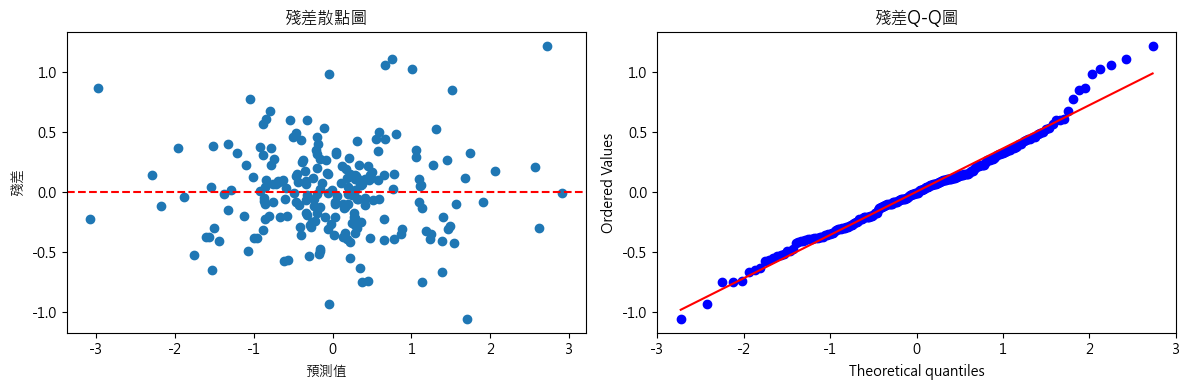

In [49]:
# 導入必要的套件
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. 刪除 Mkt 和 RF 列
factors_clean = final_factors_std.drop(['Mkt', 'RF'], axis=1)

# 2. 準備回歸數據
# 因變量
y = factors_clean['portfolio_returns']

# 自變量（所有其他因子）
X = factors_clean[['MKT_RF', 'SMB', 'HML', 'WML',  'ROA', 'RMW', 'LEV', 'INV_TURN', 'COV', 'GM', 'PEG', 'RD',  'TURN', 'LIQ', 'QUICK']]

# 3. 添加常數項
X = sm.add_constant(X)

# 4. 進行回歸
model = sm.OLS(y, X).fit()

# 5. 輸出結果
print("回歸結果摘要：")
print(model.summary())

# 6. 提取關鍵統計量
print("\n因子係數和顯著性：")
for factor, coef, pval in zip(X.columns, model.params, model.pvalues):
    print(f"{factor}:")
    print(f"  係數: {coef:.6f}")
    print(f"  P值: {pval:.6f}")

# 7. 模型整體統計量
print("\n模型整體統計：")
print(f"R平方: {model.rsquared:.4f}")
print(f"調整後R平方: {model.rsquared_adj:.4f}")
print(f"F統計量: {model.fvalue:.4f}")
print(f"F統計量P值: {model.f_pvalue:.4f}")

# 8. 殘差分析
plt.figure(figsize=(12, 4))

# 殘差散點圖
plt.subplot(121)
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('預測值')
plt.ylabel('殘差')
plt.title('殘差散點圖')
plt.axhline(y=0, color='r', linestyle='--')

# 殘差QQ圖
plt.subplot(122)
import scipy.stats as stats
stats.probplot(model.resid, dist="norm", plot=plt)
plt.title('殘差Q-Q圖')

plt.tight_layout()
plt.show()

In [50]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# 將結果轉換為DataFrame並顯示
results_df = pd.DataFrame({
    'coef': model.params,
    'std err': model.bse,
    't': model.tvalues,
    'P>|t|': model.pvalues.round(4),
    '[0.025': model.conf_int()[0],
    '0.975]': model.conf_int()[1]
})
print(results_df)


                  coef   std err             t   P>|t|    [0.025    0.975]
const    -3.642919e-17  0.025285 -1.440765e-15  1.0000 -0.049854  0.049854
MKT_RF    8.269555e-01  0.028692  2.882213e+01  0.0000  0.770384  0.883527
SMB      -3.068929e-01  0.041646 -7.369034e+00  0.0000 -0.389008 -0.224778
HML      -7.209166e-02  0.032214 -2.237900e+00  0.0263 -0.135609 -0.008575
WML       1.469988e-02  0.028683  5.124932e-01  0.6089 -0.041855  0.071255
ROA       7.090766e-02  0.075999  9.330032e-01  0.3519 -0.078942  0.220757
RMW      -4.672929e-03  0.058107 -8.041953e-02  0.9360 -0.119243  0.109898
LEV       1.339277e-01  0.046626  2.872387e+00  0.0045  0.041994  0.225861
INV_TURN -3.759282e-02  0.034939 -1.075953e+00  0.2832 -0.106483  0.031297
COV       6.341551e-02  0.061116  1.037622e+00  0.3007 -0.057088  0.183919
GM       -1.278029e-01  0.057325 -2.229460e+00  0.0269 -0.240831 -0.014775
PEG       5.184529e-02  0.070568  7.346859e-01  0.4634 -0.087295  0.190985
RD        3.135517e-02  0

C:\Users\user\AppData\Local\Temp\ipykernel_13920\3664505559.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, coef[i], '***', ha='center', va='bottom')
C:\Users\user\AppData\Local\Temp\ipykernel_13920\3664505559.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, coef[i], '**', ha='center', va='bottom')


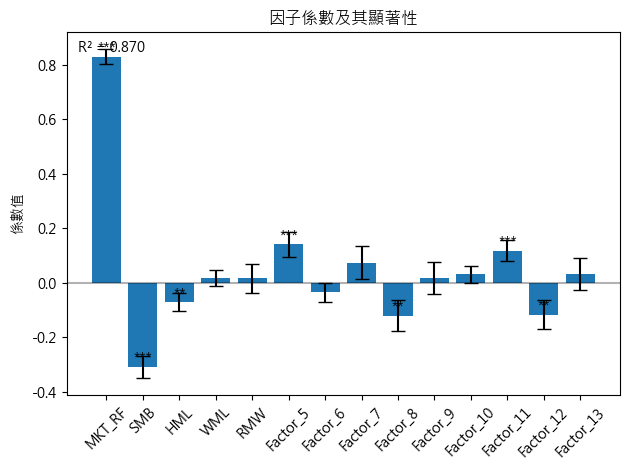

In [42]:
# ... existing code ...
# 繪製係數條形圖
bars = plt.bar(range(len(coef)), coef)
plt.errorbar(range(len(coef)), coef, yerr=errors, fmt='none', color='black', capsize=5)

# 添加顯著性標記
for i, p in enumerate(p_values):
    if p < 0.01:
        plt.text(i, coef[i], '***', ha='center', va='bottom')
    elif p < 0.05:
        plt.text(i, coef[i], '**', ha='center', va='bottom')
    elif p < 0.1:
        plt.text(i, coef[i], '*', ha='center', va='bottom')

# 設置圖表格式
# 確保標籤數量與係數數量一致
labels = ['MKT_RF', 'SMB', 'HML', 'WML', 'RMW']  # 根據實際情況調整
if len(coef) > len(labels):
    labels += ['Factor_' + str(i) for i in range(len(labels), len(coef))]  # 自動生成額外標籤

plt.xticks(range(len(coef)), labels, rotation=45)
plt.title('因子係數及其顯著性')
plt.ylabel('係數值')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 添加R方值
plt.text(0.02, 0.98, f'R² = {model.rsquared:.3f}', 
         transform=plt.gca().transAxes, 
         verticalalignment='top')

plt.tight_layout()
plt.show()
# ... existing code ...

In [48]:
import pandas as pd
import os

# 假設 final_clean 是您的數據框

# 選擇數值型列
numeric_columns = factors_clean.select_dtypes(include=['number'])

# 計算相關係數矩陣
correlation_matrix = numeric_columns.corr()

# 獲取桌面的路徑
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

# 指定輸出文件名
output_file = os.path.join(desktop_path, 'correlation_matrix.xlsx')

# 將相關係數矩陣輸出至Excel
correlation_matrix.to_excel(output_file, sheet_name='Correlation Matrix')

print(f"相關係數矩陣已輸出至 {output_file}")

相關係數矩陣已輸出至 C:\Users\user\Desktop\correlation_matrix.xlsx


In [11]:
# ... existing code ...
# 定義所有因子及其計算方式
factors_data = {
    '因子': ['LEV', 'MKT_RF', 'SMB', 'HML', 'WML', 'RMW', 'GM', 'COV', 'INV_TURN', 'PEG', 'RD', 'TURN', 'LIQ', 'QUICK'],
    '計算方式': [
        'Debt to Equity Ratio',  # LEV
        'Market Return - Risk-Free Rate',  # MKT_RF
        'Small Minus Big',  # SMB
        'High Minus Low',  # HML
        'Winners Minus Losers',  # WML
        'Robust Minus Weak',  # RMW
        'Gross Margin',  # GM
        'Coverage Ratio',  # COV
        'Inventory Turnover',  # INV_TURN
        'Price/Earnings to Growth',  # PEG
        'Research & Development',  # RD
        'Turnover Ratio',  # TURN
        'Liquidity Ratio',  # LIQ
        'Quick Ratio'  # QUICK
    ]
}

# 將因子數據轉換為 DataFrame，並設置自定義索引
factors_df = pd.DataFrame(factors_data)
factors_df.index += 1  # 將索引從1開始

# 打印因子表
print("因子及其計算方式:")
print(factors_df)
# ... existing code ...

因子及其計算方式:
          因子                            計算方式
1        LEV            Debt to Equity Ratio
2     MKT_RF  Market Return - Risk-Free Rate
3        SMB                 Small Minus Big
4        HML                  High Minus Low
5        WML            Winners Minus Losers
6        RMW               Robust Minus Weak
7         GM                    Gross Margin
8        COV                  Coverage Ratio
9   INV_TURN              Inventory Turnover
10       PEG        Price/Earnings to Growth
11        RD          Research & Development
12      TURN                  Turnover Ratio
13       LIQ                 Liquidity Ratio
14     QUICK                     Quick Ratio
